In [1]:
import pandas as pd
import plotly.express as px
from pymongo import MongoClient
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from dln import (
    true_dln_learning_coefficient
)

# Querying data from DB and parsing

In [6]:

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['dln_lambdahat']
# db = client['dln_lambdahat_dev']
collection = db['runs']

# Query data
# EXPT_NAME = "dev"
# EXPT_NAME = "random_sv_20231213"
# EXPT_NAME = "batch500_width10-100_layer2-20_sv_202312130129"
# EXPT_NAME = "batch500_width10-100_layer2-10_sv_202312131012"
# EXPT_NAME = "batch500_width10-100_layer2-10_sv_202312131121"
# EXPT_NAME = "batch500_width2-10_layer5_sv_202312131342" # fix layer=5, vary widths 2-20
# EXPT_NAME = "batch500_width2-10_layer5_sv_202312131424" # fix widths=5, vary layer=2-20
# EXPT_NAME = "zerotruth_batch500_width10-100_layer2-20_sv_202312132339"

# EXPT_NAME = "randsv_batch500_width10-50_layer2-15_sv_202312141156"
EXPT_NAME = "randsv_batch500_width10-50_layer2-15_sv_202312141203"

query = {
    "config.expt_name": EXPT_NAME, 
    "status": "COMPLETED", 
    # "_id": 28
}
projection = {
    "epsilon": "$config.sgld_config.epsilon", 
    "num_steps": "$config.sgld_config.num_steps",
    "input_dim": "$config.input_dim",
    "layer_widths": "$config.layer_widths",
    "lambdahat": "$info.lambdahat",
    "true_lambda": "$info.true_lambda",
    "true_rank": "$info.true_rank",
    "loss_trace": "$info.loss_trace",
    "init_loss": "$info.init_loss",
    "true_multiplicity": "$info.true_multiplicity",
}
sample_doc = collection.find_one(query)


# Create DataFrame
print("Creating dataframe...")
df_data = pd.DataFrame(list(collection.find(query, projection)))
print(f"Num expt: {df_data.shape[0]}")

model_dims = []
avg_widths = []
for i, row in df_data.iterrows():
    widths = [row["input_dim"]] + list(row["layer_widths"])
    model_dim = np.sum([widths[i] * widths[i + 1] for i in range(len(widths) - 1)])
    model_dims.append(model_dim)
    avg_widths.append(np.mean(widths))
df_data["model_dim"] = model_dims
df_data["avg_width"] = avg_widths
df_data["num_layers"] = [len(x) for x in df_data["layer_widths"]]
df_data["first_nan_index"] = [
    list(np.isnan(trace)).index(True) if np.any(np.isnan(trace)) else None 
    for trace in df_data["loss_trace"]
]

if "true_multiplicity" not in df_data.columns:
    print("computing multiplicty... ")
    df_data["true_multiplicity"] = [
        true_dln_learning_coefficient(row["true_rank"], row["layer_widths"], row["input_dim"])[1]
        for _, row in df_data.iterrows()
    ]


df_data.head()

Creating dataframe...
Num expt: 100
computing multiplicty... 


,_id,epsilon,num_steps,input_dim,layer_widths,lambdahat,true_lambda,true_rank,loss_trace,init_loss,model_dim,avg_width,num_layers,first_nan_index,true_multiplicity
0,963,0.00001,20000,11,"[44, 14, 22, 16]",108.470215,88.0,11,"[0.015839818865060806, 0.02629844658076763, 0....",0.0,1760,21.400000,4,NaN,1.0
1,964,0.00001,20000,19,"[20, 40, 13, 47, 23]",237.520950,188.5,13,"[0.018447911366820335, 0.031474679708480835, 0...",0.0,3392,27.000000,5,NaN,1.0
2,965,0.00001,20000,18,"[18, 28, 20, 22, 34, 29]",246.329666,261.0,18,"[0.01522472221404314, 0.024790214374661446, 0....",0.0,3562,24.142857,6,NaN,1.0
3,966,0.00001,20000,16,"[22, 23, 21, 45]",326.698792,360.0,16,"[0.011780436150729656, 0.022785764187574387, 0...",0.0,2286,25.400000,4,NaN,1.0
4,967,0.00001,20000,12,"[49, 16, 48, 24, 11, 35, 19, 43, 19, 21, 19, 3...",NaN,264.0,11,"[0.00935305841267109, 0.015486063435673714, 0....",0.0,9621,28.000000,14,7023.0,1.0


---
# Plotting
---

## Some diagnostics

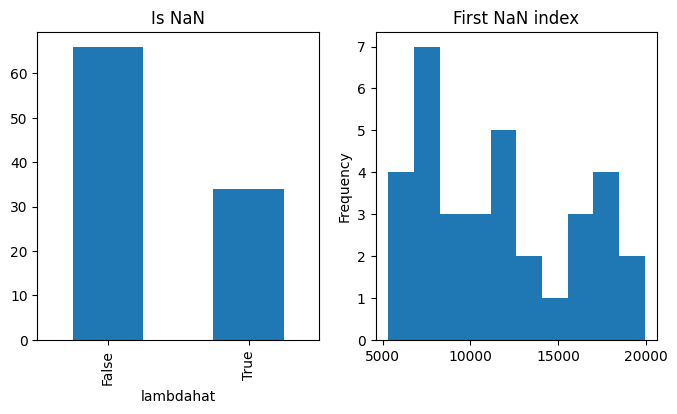

In [7]:

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes[0]
np.isnan(df_data["lambdahat"]).value_counts().plot(kind='bar', ax=ax)
ax.set_title("Is NaN")
ax = axes[1]
df_data["first_nan_index"].plot(kind="hist", ax=ax)
ax.set_title("First NaN index");

In [8]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_data["model_dim"], nbinsx=20))
fig.update_layout(
    title="Model Parameter Count"
)

## $\lambda$ vs $\hat{\lambda}$

In [9]:
df = df_data
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["lambdahat"], 
    mode='markers', 
    marker=dict(size=5),
    name='lambdahat'
))

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["true_rank"], 
    mode='markers', 
    marker=dict(size=5),
    name='true_rank'
))

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["model_dim"] / 2, 
    mode='markers', 
    marker=dict(size=5, color='green'),
    name='model dimension / 2'
))


fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["true_multiplicity"], 
    mode='markers', 
    marker=dict(size=5, color='purple'),
    name='multiplicity'
))


# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(go.Scatter(
    x=sorted_true_lambda, 
    y=sorted_true_lambda, 
    mode='lines', 
    line=dict(dash='dash', color='red', width=2),
    name='true_lambda'
))

fig.update_layout(
    title="Comparison of Metrics",
    xaxis_title="True lambda",
    yaxis_title="Metrics",
    legend_title="Legend",
    width=800,
    height=800
)


In [7]:

fig = px.scatter(
    df, 
    x="true_lambda", 
    y="lambdahat", 
    color="true_multiplicity",
    # color="avg_width",
    # color="model_dim",
    # color="num_layers",
    size="num_layers",
    # size="true_rank",
    labels={
        "true_lambda": "True lambda",
        "lambdahat": "lambdahat",
        "model_dim": "Model Dimension",
        "num_layers": "Number of Layers",
        "true_rank": "True Rank"
    },
    title="Scatter Plot of True Lambda vs Lambdahat"
)

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(
    px.line(
        x=sorted_true_lambda, 
        y=sorted_true_lambda
    ).data[0]
)

# Update the layout
fig.update_layout(
    xaxis_title="True lambda",
    yaxis_title="Lambdahat",
    legend_title="Legend",
    width=800,
    height=800
)


## Loss trace

In [10]:
sample_loss_trace = sample_doc["info"]["loss_trace"]
distances = sample_doc["info"]["sgld_distances"]
nsamples = len(sample_loss_trace)
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=list(range(len(sample_loss_trace))),
#     y=sample_loss_trace,
#     mode='lines+markers',
#     marker=dict(symbol='circle', size=2),
#     line=dict(color='blue'),
#     name='Loss Trace'
# ))

# fig.update_layout(
#     xaxis_title='Index',
#     yaxis_title='Loss',
#     title='Sample Loss Trace'
# )



fig = go.Figure()

# Add trace for loss_trace
fig.add_trace(
    go.Scatter(
        x=list(range(nsamples)),
        y=sample_loss_trace,
        name="Loss Trace",
        yaxis="y1"
    )
)

# Add trace for distances
fig.add_trace(
    go.Scatter(
        x=list(range(nsamples)),
        y=distances,
        name="Distances",
        yaxis="y2"
    )
)

# Set layout for the graph
fig.update_layout(
    title="Loss Trace and Distances",
    xaxis_title="Sample Index",
    yaxis=dict(
        title="Loss Trace",
        side="left",
        showgrid=False,
        zeroline=False
    ),
    yaxis2=dict(
        title="Distances",
        side="right",
        overlaying="y",
        showgrid=False,
        zeroline=False
    )
)



In [294]:
fig = go.Figure()
distances = sample_doc["info"]["sgld_distances"]
# fig.add_trace(go.Histogram(y=sample_doc["info"]["sgld_distances"]))
fig.add_trace(go.Scatter(
    x=list(range(len(distances))), 
    y=distances, 
    mode='markers', 
    marker=dict(size=5),
    name="l2_distance"
))

## Effects of `sgld_config.num_steps`

In [295]:
s = 500
sgld_num_steps = sample_doc["config"]["sgld_config"]["num_steps"]
n = sample_doc["config"]["num_training_data"]
data = []

# df = df_data[~np.isnan(df_data["lambdahat"])]
df = df_data

for i, row in df.iterrows():
    expt_id = row["_id"]
    trace = row["loss_trace"]
    init_loss = row["init_loss"]
    true_lambda = row["true_lambda"]
    for nstep in range(s, sgld_num_steps + 1, s):
        nstep_lambdhat = (np.mean(trace[:nstep]) - init_loss) * n / np.log(n)
        data.append([expt_id, nstep, nstep_lambdhat, true_lambda])
df = pd.DataFrame(data, columns=["_id", "nstep", "lambdahat", "true_lambda"])

fig = px.scatter(
    df, 
    x="true_lambda", 
    y="lambdahat", 
    color="nstep",
    labels={
        "true_lambda": "True lambda",
        "lambdahat": "lambdahat",
        "nstep": "Num SGLD step"
    },
    title="True Lambda vs Lambdahat"
)

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(
    px.line(
        x=sorted_true_lambda, 
        y=sorted_true_lambda
    ).data[0]
)

# Update the layout
fig.update_layout(
    xaxis_title="True lambda",
    yaxis_title="Lambdahat",
    legend_title="Legend",
    width=800,
    height=800, 
    # yaxis_type="log", 
    # xaxis_type="log",
)
